In [78]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [79]:
train=pd.read_csv('/Users/yangqingqing/Desktop/Titanic/train.csv')
test=pd.read_csv('/Users/yangqingqing/Desktop/Titanic/test.csv')
PassengerId = test['PassengerId']

all_data=[train,test]#list

train['Name_len']=train['Name'].apply(len)
test['Name_len']=test['Name'].apply(len)

train['has_Cabin']=train['Cabin'].apply(lambda x :0 if type(x)==float else 1)
test['has_Cabin']=test['Cabin'].apply(lambda x :0 if type(x)==float else 1)

for data in all_data:
    data['FamilySize']=data['SibSp']+data['Parch']+1#将家庭成员个数规划为1和0两种
    #print(data['FamilySize'])
for data in all_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
    
    
    
for data in all_data:
    data['Embarked']=data['Embarked'].fillna('S')#embarked缺失用S代替
    
for dataset in all_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for data in all_data:
    age_avg = data['Age'].mean()
    age_std = data['Age'].std()#样本标准差
    age_null_count = data['Age'].isnull().sum()#统计年龄为空的数目
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)#将缺失值补全
    data['Age'][np.isnan(data['Age'])] = age_null_random_list#
    data['Age'] = data['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)#将年龄划分为5份

In [80]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
for data in all_data:
    data['Title'] = data['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for data in all_data:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [81]:
for dataset in all_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [82]:
drop_elements=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train=train.drop(drop_elements,axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test=test.drop(drop_elements,axis=1)
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_len,has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


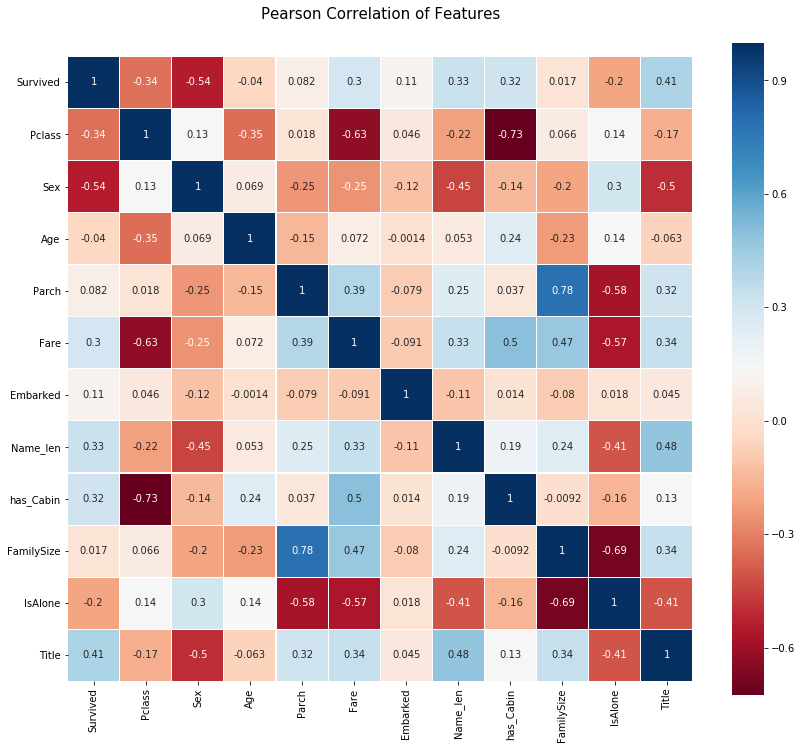

In [83]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#热图用来显示特征之间的皮尔森相关性

In [113]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]#训练的样本数
ntest = test.shape[0]#测试的样本数
SEED = 0 # 随机种子
NFOLDS = 5 # 5次交叉验证
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)#k折吧=5

# 用于fit predict等操作
#def init：用于调用该类的默认构造函数的Python标准。
#这意味着当你想创建一个对象（分类器）时，你必须给它clf的参数（你想要什么sklearn分类器），种子（随机种子）和参数（分类器的参数）
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):#和拟合没啥差别fit
        self.clf.fit(x_train, y_train)

    def predict(self, x):#进行预测
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):#判断特征重要性的函数
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [160]:
#现在正如在前面部分中提到的那样，堆叠使用基础分类器的预测作为对第二级模型的训练的输入。 然而，不能简单地在完整训练数据上训练基础模型，
#在完整测试集上产生预测，然后输出这些用于第二级训练。 这会带来基本模型预测时过度拟合的风险。
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))#产生训练对应样本个数一样的array
    oof_test = np.zeros((ntest,))#产生测试对应样本个数一样的array
    oof_test_skf = np.empty((NFOLDS, ntest))#5*test样本的矩阵

    for i, (train_index, test_index) in enumerate(kf):#进行交叉验证的感觉，5次
#         if i==1:
#             print(train_index)
#             print("*************************")
#             print(test_index)
        x_tr = x_train[train_index]#原本的train分为train_index和test_index，比例为4:1
        y_tr = y_train[train_index]#survived的结果
        
        x_te = x_train[test_index]#测试集

        clf.train(x_tr, y_tr)#clf分类器起训练样本

        oof_train[test_index] = clf.predict(x_te)#将训练好的clf加到test_index测试集上进行预测
        oof_test_skf[i, :] = clf.predict(x_test)#原本的测试集test预测

    oof_test[:] = oof_test_skf.mean(axis=0)#对5次的预测取平均,得到最后的test的预测指为418个
    print(oof_train)#891个训练的
    print("****************************************")
    #print(oof_test.shape[0])#418个测试的
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [161]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,#指训练过程的cores数，为-1指所有的core都被使用
    'n_estimators': 500,#分类器的个数
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,#数的深度，被设置的过高将产生过拟合的风险
    'min_samples_leaf': 2,#
    'max_features' : 'sqrt',#
    'verbose': 0#学习过程中控制是否文本输出，为0表示无文本
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [162]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [163]:
#y_train = train['Survived'].ravel()
#train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data
y_train[0]
x_train[0]

array([ 3,  1,  1,  0,  0,  0, 23,  0,  2,  0,  1])

In [164]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
#调用上面的交叉验证得到每种分类器对应的train和test预测值
print("Training is complete")
#et_oof_train(891, 1)
#et_oof_test(418, 1)

[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.

[0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1.

In [149]:
#针对每个模型都评价出其特征的重要性，11个特征目前。调用的是SklearnHelper里面的feature_importances（）函数
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12535655 0.20207351 0.02859524 0.02128094 0.07231344 0.02363572
 0.11033922 0.06404564 0.06789693 0.01345483 0.27100799]
[0.12157163 0.37927659 0.02630332 0.01621167 0.05517765 0.02826001
 0.0478408  0.08282482 0.04487891 0.02171859 0.175936  ]
[0.03  0.01  0.022 0.064 0.036 0.01  0.686 0.012 0.052 0.004 0.074]
[0.07583609 0.03780515 0.11101279 0.02910526 0.09767883 0.05261605
 0.40583738 0.02497468 0.06812002 0.02081562 0.07619814]


In [125]:
rf_features=[0.12535655,0.20207351 ,0.02859524 ,0.02128094 ,0.07231344 ,0.02363572,
 0.11033922, 0.06404564, 0.06789693, 0.01345483, 0.27100799]
et_features=[0.12157163, 0.37927659, 0.02630332 ,0.01621167 ,0.05517765, 0.02826001,
 0.0478408,  0.08282482 ,0.04487891, 0.02171859 ,0.175936  ]
ada_features=[0.03 , 0.01 , 0.022 ,0.064 ,0.036 ,0.01 , 0.686, 0.012 ,0.052 ,0.004, 0.074]
gb_features=[0.07583609 ,0.03780515, 0.11101279, 0.02910526 ,0.09767883 ,0.05261605,
 0.40583738, 0.02497468, 0.06812002, 0.02081562, 0.07619814]

In [126]:
cols = train.columns.values
print(cols)
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })


['Pclass' 'Sex' 'Age' 'Parch' 'Fare' 'Embarked' 'Name_len' 'has_Cabin'
 'FamilySize' 'IsAlone' 'Title']


In [127]:
# 把各个特征的重要性用点图表示出来
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [128]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)
#每种分类器下哪种特征更重要

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.030,0.121572,0.075836,0.125357,Pclass,0.088191
1,0.010,0.379277,0.037805,0.202074,Sex,0.157289
2,0.022,0.026303,0.111013,0.028595,Age,0.046978


In [129]:
#图标显示每个特征的重要性
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [150]:
#第一级分类预测的结果已经完成，现在将第一级的作为输入，就是上面交叉验证的结果，4个模型的结果
#会得到一些新的特征集合用于第二级的输入
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
     'svc': svc_oof_train.ravel()
    })
base_predictions_train.head()#指的是第一级分类预测结果，4个模型分别得到的最终结果

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,svc
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [151]:
#第二级训练集的相关性热图
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [173]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)

x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

print(x_train.shape)
print(type(x_train))
print(et_oof_train.shape)
print(rf_oof_train.shape)

(891, 5)
<class 'numpy.ndarray'>
(891, 1)
(891, 1)


In [153]:
#用xgboost作为第二级的学习模型
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,#树的深度
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,#最小化损失函数                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)#拟合数据,这次不是对特征来拟合而是对不同分类器得到的结果来进行拟合
predictions = gbm.predict(x_test)#进行预测

In [154]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [179]:
a = np.array([[1,2,3],[4,5,6]])
b = np.zeros((2,3))
print(a.shape)
c=np.ones((2,3))
d = np.concatenate((a,b,c),axis=1)
print(type(a))
print(d)
print(d.shape)

(2, 3)
<class 'numpy.ndarray'>
[[1. 2. 3. 0. 0. 0. 1. 1. 1.]
 [4. 5. 6. 0. 0. 0. 1. 1. 1.]]
(2, 9)
